In [15]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [16]:
import numpy as np

import matplotlib.pyplot as plt

from lambeq import BobcatParser
from lambeq import AtomicType, IQPAnsatz, remove_cups
from lambeq import TketModel, NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from discopy import grammar
from discopy import Dim

from pytket.extensions.qiskit import AerBackend
from pytket.circuit.display import render_circuit_jupyter

In [17]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

In [18]:
#Input data MC1
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            #sentences are split by , in our data set
            end_sentence = line.split(",")
            t = int(end_sentence[2])
            labels.append([t, 1-t])
            #there are two sentences per associated label
            #we need to make sure they are both used
            sentences.append(end_sentence[0])
            sentences.append(end_sentence[1])
    return labels, sentences

In [19]:
#we will use 15% of the data as a training set
labels, data = read_data('MC1.TXT')
train_label, train_data = labels[0:15] , data[0:15]
test_label, test_data = labels[15:100] , data[15:100]

tag = []

#associate train_circuit to tags
food_keywords = ['chef','dish','meal','tasty','prepares']
code_keywords = ['programmer','code','hacker','writes']

positive_keywords = ['skilful','devoted','tasty','creates']

def label_data(all_data):
    tag = []

    for i in range(np.size(all_data)):
        words = [word for word in all_data[i].split()]
        for l in words:
            for j in food_keywords:
                if l == j:
                    a = 0

            for k in code_keywords:
                if l == k:
                    a = 1
            
            for h in positive_keywords:
                if l == h :
                    b = 1
                else:
                    b = 0
        
        tag.append([a,b])
    return tag


#rewrite training labels
train_labels = label_data(train_data)
test_labels = label_data(test_data)


In [20]:
#Parser
parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')
train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


In [21]:
train_diagrams = [
    diagram.normal_form()
    for diagram in train_diagrams if diagram is not None]
test_diagrams = [
    diagram.normal_form()
    for diagram in test_diagrams if diagram is not None]

train_labels = [
    label for (diagram, label)
    in zip(train_diagrams, train_labels)
    if diagram is not None]
test_labels = [
    label for (diagram, label)
    in zip(test_diagrams, test_labels)
    if diagram is not None]

In [22]:
#Circuits
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

In [23]:
#render circuits
render_circuit_jupyter(train_circuits[14].to_tk())

In [24]:
#Model
all_circuits = train_circuits + test_circuits

backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

#Training from diagrams
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

In [25]:
#Loss & eval metrics
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}

In [26]:
#Trainer
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)


In [27]:
#Create datasets
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)
test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

In [28]:
#Train model
trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=100)

Epoch 1:    train/loss: 2.8839   valid/loss: 0.4632   train/acc: 0.3333   valid/acc: 0.5882
Epoch 100:  train/loss: 0.2395   valid/loss: 0.2180   train/acc: 0.7667   valid/acc: 0.5882

Training completed!


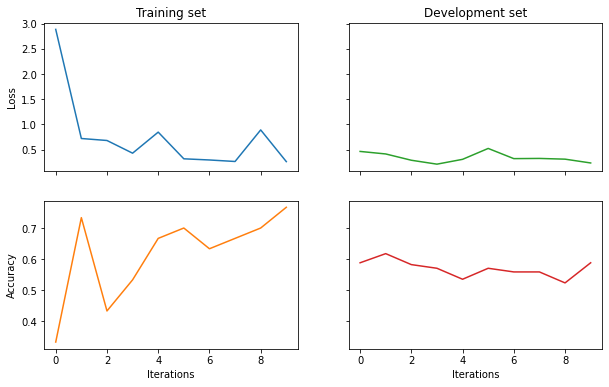

In [29]:
#Printing train model
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

Note: current model compares tuples - there are more efficient ways of comparing the sentences that will consider the cohesion and structure behind each sentence instead of the separate items that make it what it is